**This study utilized partial dataset (1000 cat images and 1000 dog images) of the [2013 Kaggle Dogs vs. Cats competition](https://www.kaggle.com/c/dogs-vs-cats). to examin how the three factors may impact a convolutional neural network (CNN) performance: (1) image color; (2) image size; and (3) pooling-layer type. Each factor has two levels: image color (gray: channel=1/color: channel=3), image size (64x64/128x128), and pooling-layer (max_pooling/average_pooling). Thus, this benchmark experiment was conducted with a 2x3 factorial design.**

**Keras from tensorflow was used to construct two CNN models: (1) CNN_max consistes of 1 convolutional layer (32, 5x5 + 1(S)), 1 max-pooling layer(2x2 + 2), 1 fully-connected layer(100 neurons, ReLu) followed by dropout rate = 0.4, and 1 output layer (2 neurons corresponding to the 2 classes); (2) CNN_avg consists of 1 convolutional layer (32, 5x5 + 1(S)), 1 avg-pooling layer(2x2 + 2), 1 fully-connected layer(100 neurons, ReLu) with dropout rate = 0.4, and 1 output layer (2 neurons corresponding to the 2 classes). Each of the four (4) data sets was devided into train/development/test sets in 60/20/20 ratio. Each model was trained on the train set and validated on the development set before it's deployed to evaluate the test set.**

**The results from our eight (8) experiments show that**: 
1. When larger images (128x128) are used for model training and development, the accuracy of the model is mostly higher than that when smaller images (64x64) are utilized.
2. When images in color (channel=3) are used for model training and development, the model consistently outperforms that built with gray images (channel=1), no matter of the image size or the type of pooling-layer.
3. Max_pooling method is recommended.
    
**While it is evident that it takes much longer time to train and develop the CNN model if larger colorful image (128x128, channel=3) are used, the mangement's primary concern is achieving the highest possible accuracy in image classification. Therefore, it is recommended to utilize higher-resolution images (128x128) in RGB color (channel=3) for training and development of CNN model with max_pooling layer designed within , at the cost of runtime.**

# SETUP

Import packages needed for this study.

In [1]:
import numpy as np
import os
import time
import pandas as pd
from collections import OrderedDict

Import function from scikit-learn.

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

Import tensorflow and keras.

In [3]:
import tensorflow as tf
from tensorflow import keras

Plotting setup.

In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

Utility function setup to plot grayscale and RGB images.

In [5]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")

Make the output stable across runs.

In [6]:
Random_Seed = 42

In [7]:
def reset_graph(seed=Random_Seed):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# CATS AND DOGD DATASET

Load in .npy files. The following codes are adopted from Miller (2018) run-cats-dogs-jump-start-dnn-v002.py.

In [8]:
cats_1000_64_64_1 = np.load('cats_1000_64_64_1.npy')
dogs_1000_64_64_1 = np.load('dogs_1000_64_64_1.npy')
cats_1000_128_128_1 = np.load('cats_1000_128_128_1.npy')
dogs_1000_128_128_1 = np.load('dogs_1000_128_128_1.npy')
cats_1000_64_64_3 = np.load('cats_1000_64_64_3.npy')
dogs_1000_64_64_3 = np.load('dogs_1000_64_64_3.npy')
cats_1000_128_128_3 = np.load('cats_1000_128_128_3.npy')
dogs_1000_128_128_3 = np.load('dogs_1000_128_128_3.npy')

Stack the numpy arrays to form input data.

In [9]:
X_64g = np.concatenate((cats_1000_64_64_1, dogs_1000_64_64_1), axis = 0) 
X_128g = np.concatenate((cats_1000_128_128_1, dogs_1000_128_128_1), axis = 0)
X_64c = np.concatenate((cats_1000_64_64_3, dogs_1000_64_64_3), axis = 0)
X_128c = np.concatenate((cats_1000_128_128_3, dogs_1000_128_128_3), axis = 0)
X_cats_dogs = [X_64g, X_128g, X_64c, X_128c]

Define the labels to be used 1000 cats = 0 1000 dogs = 1

In [10]:
y_cat_dog = np.concatenate((np.zeros((1000), dtype = np.int32), 
                      np.ones((1000), dtype = np.int32)), axis = 0)

Visualize the first picture in each four data sets. 

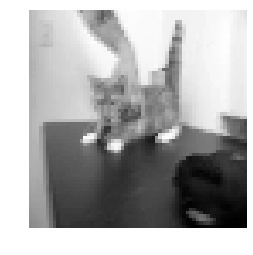

In [11]:
plot_image(X_64g[0, :, :, 0])

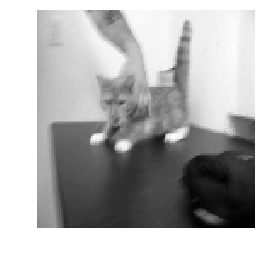

In [12]:
plot_image(X_128g[0, :, :, 0])

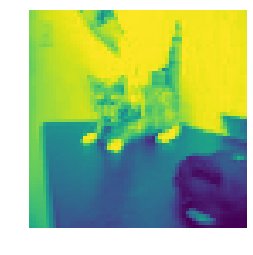

In [13]:
plot_color_image(X_64c[0, :, :, 0])

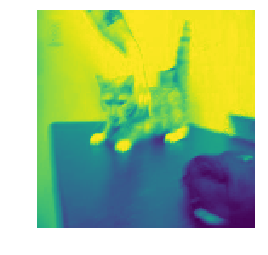

In [14]:
plot_color_image(X_128c[0, :, :, 0])

Set up scaler to later rescale the train/dev/test data set before feeding to the CNN model.

In [15]:
scaler = MinMaxScaler()
scaler.fit(np.array([0., 255.]).reshape(-1,1))

MinMaxScaler(copy=True, feature_range=(0, 1))

# DEFINE FUNCTIONS TO BUILD CNN MODELS

Define function CNN_max_mode which uses Keras to build a CNN model consisting of 1 convolutional layer (32, 5x5 + 1(S)), 1 max-pooling layer(2x2 + 2), 1 fully-connected layer(100 neurons, ReLu) with dropout rate = 0.4, and 1 output layer (2 neurons corresponding to the 2 classes). Codes are adopted from [Maynard-Reid (2018) Fashion-MNIST with tf.Keras](https://medium.com/tensorflow/hello-deep-learning-fashion-mnist-with-keras-50fcff8cd74a) 

In [16]:
def CNN_max_model (height, width, channel):
    model_max = tf.keras.Sequential()
    model_max.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(5, 5), 
                                         strides=(1, 1), padding='same', 
                                         activation='relu', 
                                         input_shape=(height, width, channel))) 
    model_max.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model_max.add(tf.keras.layers.Flatten())
    model_max.add(tf.keras.layers.Dense(100, activation='relu'))
    model_max.add(tf.keras.layers.Dropout(0.4))
    model_max.add(tf.keras.layers.Dense(2, activation='softmax'))

    return model_max;

Define function CNN_avg_mode which uses Keras to build a CNN model consisting of 1 convolutional layer (32, 5x5 + 1(S)), 1 average-pooling layer(2x2 + 2), 1 fully-connected layer(100 neurons, ReLu) with dropout rate = 0.4, and 1 output layer (2 neurons corresponding to the 2 classes). Codes are adopted from [Maynard-Reid (2018) Fashion-MNIST with tf.Keras](https://medium.com/tensorflow/hello-deep-learning-fashion-mnist-with-keras-50fcff8cd74a) 

In [17]:
def CNN_avg_model (height, width, channel):
    model_avg = tf.keras.Sequential()
    model_avg.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(5, 5), 
                                         strides=(1, 1), 
                                         padding='same', activation='relu', 
                                         input_shape=(height, width, channel))) 
    model_avg.add(tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
    model_avg.add(tf.keras.layers.Flatten())
    model_avg.add(tf.keras.layers.Dense(100, activation='relu'))
    model_avg.add(tf.keras.layers.Dropout(0.4))
    model_avg.add(tf.keras.layers.Dense(2, activation='softmax'))

    return model_avg;

# BENCHMARK EXPERIMENT WITH 2X3 FACTORIAL DESIGN

Set up numpy array to store test results.

In [18]:
heights=[]
widths=[]
channels=[]
accuracy_test=[]
loss_test=[]
processing_time=[]

**Experiment with CNN_max_model.**

For each of the four data sets which are the four combinations of two (2) of the three (3) factors in this experiment: image size (64x64/128x128), and image color (gray: channel=1/color: channel=3), we split it into train/development/test (60/20/20). First, we train the CNN_max model on each of the train set and evaluate on its corresponding development set. The time spent on training and developing will be recorded for each run.

In [19]:
for X_cat_dog in X_cats_dogs:
    start_time = time.clock()
    X_inputs=[]
    batch_size, height, width, channel = X_cat_dog.shape
    X_cat_dog = X_cat_dog.reshape(-1,height*width*channel)
    X_train, X_test, y_train, y_test = train_test_split(X_cat_dog, y_cat_dog, 
                                                        test_size=0.2, 
                                                        random_state=Random_Seed)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                      test_size=0.2, 
                                                      random_state=Random_Seed)
    for X in (X_train, X_val, X_test):
        X_MinMax=scaler.transform(X)
        X_input=X_MinMax.reshape(-1, height, width, channel)
        X_inputs.append(X_input)
    model = CNN_max_model(height, width, channel)
    model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
    model.fit(X_inputs[0], y_train, batch_size=64, epochs=10, 
              validation_data=(X_inputs[1], y_val))
    score = model.evaluate(X_inputs[2], y_test, verbose=0)
    end_time=time.clock()
    processing=end_time-start_time
    heights.append(height)
    widths.append(width)
    channels.append(channel)
    accuracy_test.append(score[1])
    loss_test.append(score[0])
    processing_time.append(processing)

Train on 1280 samples, validate on 320 samples
Epoch 1/10
1280/1280 [==============================] - 5s 4ms/step - loss: 0.9688 - acc: 0.5109 - val_loss: 0.6900 - val_acc: 0.5813
Epoch 2/10
1280/1280 [==============================] - 5s 4ms/step - loss: 0.6896 - acc: 0.5516 - val_loss: 0.6899 - val_acc: 0.4906
Epoch 3/10
1280/1280 [==============================] - 5s 4ms/step - loss: 0.6614 - acc: 0.6266 - val_loss: 0.6853 - val_acc: 0.5094
Epoch 4/10
1280/1280 [==============================] - 5s 4ms/step - loss: 0.5932 - acc: 0.7219 - val_loss: 0.6204 - val_acc: 0.6844
Epoch 5/10
1280/1280 [==============================] - 5s 4ms/step - loss: 0.5272 - acc: 0.7477 - val_loss: 0.6027 - val_acc: 0.6875
Epoch 6/10
1280/1280 [==============================] - 5s 4ms/step - loss: 0.4252 - acc: 0.8250 - val_loss: 0.5853 - val_acc: 0.6937
Epoch 7/10
1280/1280 [==============================] - 5s 4ms/step - loss: 0.3607 - acc: 0.8633 - val_loss: 0.5955 - val_acc: 0.7031
Epoch 8/10
1280

**Experiment with CNN_avg_model.**

For each of the four data sets which are the four combinations of two (2) of the three (3) factors in this experiment: image size (64x64/128x128), and image color (gray: channel=1/color: channel=3), we split it into train/development/test (60/20/20). First, we train the CNN_avg model on each of the train set and evaluate on its corresponding development set. The time spent on training and developing will be recorded for each run.

In [24]:
for X_cat_dog in X_cats_dogs:
    start_time = time.clock()
    X_inputs=[]
    batch_size, height, width, channel = X_cat_dog.shape
    X_cat_dog = X_cat_dog.reshape(-1,height*width*channel)
    X_train, X_test, y_train, y_test = train_test_split(X_cat_dog, y_cat_dog, 
                                                        test_size=0.2, 
                                                        random_state=Random_Seed)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                      test_size=0.2, 
                                                      random_state=Random_Seed)
    for X in (X_train, X_val, X_test):
        X_MinMax=scaler.transform(X)
        X_input=X_MinMax.reshape(-1, height, width, channel)
        X_inputs.append(X_input)
    model = CNN_avg_model(height, width, channel)
    model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
    model.fit(X_inputs[0], y_train, batch_size=64, epochs=10, 
              validation_data=(X_inputs[1], y_val))
    score = model.evaluate(X_inputs[2], y_test, verbose=0)
    end_time=time.clock()
    processing=end_time-start_time
    heights.append(height)
    widths.append(width)
    channels.append(channel)
    accuracy_test.append(score[1])
    loss_test.append(score[0])
    processing_time.append(processing)

Train on 1280 samples, validate on 320 samples
Epoch 1/10
1280/1280 [==============================] - 5s 4ms/step - loss: 0.8232 - acc: 0.4977 - val_loss: 0.6986 - val_acc: 0.4500
Epoch 2/10
1280/1280 [==============================] - 4s 3ms/step - loss: 0.6898 - acc: 0.5281 - val_loss: 0.6896 - val_acc: 0.5969
Epoch 3/10
1280/1280 [==============================] - 5s 4ms/step - loss: 0.6811 - acc: 0.6117 - val_loss: 0.6811 - val_acc: 0.6000
Epoch 4/10
1280/1280 [==============================] - 5s 4ms/step - loss: 0.6587 - acc: 0.6633 - val_loss: 0.6557 - val_acc: 0.6906
Epoch 5/10
1280/1280 [==============================] - 5s 4ms/step - loss: 0.6017 - acc: 0.7156 - val_loss: 0.6229 - val_acc: 0.6813
Epoch 6/10
1280/1280 [==============================] - 5s 4ms/step - loss: 0.5490 - acc: 0.7430 - val_loss: 0.6104 - val_acc: 0.6875
Epoch 7/10
1280/1280 [==============================] - 5s 4ms/step - loss: 0.5033 - acc: 0.7883 - val_loss: 0.5966 - val_acc: 0.7031
Epoch 8/10
1280

# RESULTS AND CONCLUSION

In [25]:
name=[['max-pooling'], ['avg-pooling']]
names=np.repeat(name, 4)

In [46]:
results = pd.DataFrame(OrderedDict([
                        ('channel', channels),
                        ('height', heights),
                        ('width', widths),
                        ('pooling-layer', names),
                        ('accuracy on test', accuracy_test),
                        ('time', processing_time),
                        ('loss on test', loss_test),
                        ]))

In [47]:
print(results)

   channel  height  width pooling-layer  accuracy on test        time  \
0        1      64     64   max-pooling            0.8050   50.987981   
1        1     128    128   max-pooling            0.7800  197.805428   
2        3      64     64   max-pooling            0.8200   66.239383   
3        3     128    128   max-pooling            0.8500  259.951935   
4        1      64     64   avg-pooling            0.7450   49.635541   
5        1     128    128   avg-pooling            0.7875  190.845519   
6        3      64     64   avg-pooling            0.8025   64.735494   
7        3     128    128   avg-pooling            0.8400  253.901873   

   loss on test  
0      0.494823  
1      0.685610  
2      0.407661  
3      0.517714  
4      0.512912  
5      0.573515  
6      0.487256  
7      0.465183  


As the management is most concerned about achieving the highest possible accuracy in image classification, we will focus on how each factor impact the accuracy of the model.

First, we examin the impact of image size (64x64/128x128) on model performance (test accuracy). When larger images (128x128) are used for model training and development, the accuracy of the model is mostly higher than that when smaller images (64x64) are utilized. This is evident by the fact that the accuracy-on-test of experiment 4(128x128) is higher than that of experiment 3(64x64), accuracy-on-test of experiment 6(128x128) is higher than that of experiment 5(64x64), and accuracy-on-tes of experiment 8(128x128) is higher than that of experiment 7(64x64).  

Second, we zoom in on the impact of image color (gray: channel=1/color: channel=3) on model performance. When images in color (channel=3) are used for model training and development, the model consistently outperforms that built with gray images (channel=1), no matter of the image size or the type of pooling-layer. This is evident by the fact that the accuracy-on-test of experiment 3 (channel=3) is higher than that of experiment 1(channel=1), the accuracy-on-test of experiment 4 (channel=3) is higher than that of experiment 2 (channel=1), the accuracy-on-test of experiment 7 (channel=3) is higher than that of experiment 5 (channel=1), and the accuracy-on-test of experiment 8 (channel=3) is higher than that of experiment 6 (channel=1).

Last but not least, we are interested in the impact of pooling-layer type on the model performance. We notice that when max_pooling layer is utilized, the model either outperform or performs closely to the model with avg_pooling layer. Therefore, max_pooling is recommended over average_pooling method.